In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/optimum/20210804_classification

/content/gdrive/My Drive/optimum/20210804_classification


In [3]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import auc, roc_curve, accuracy_score, f1_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [107]:
data = pd.read_excel('data.xlsx')

In [108]:
data.tail()

,3089920,-6998680,3090080,-6998680.1,3089920.1,-6998520,3090080.1,-6998520.1,1,3
1103,-1604,-7094000,-1424,-7094000,-12418,-7094000,-12418,-7093820,0,3
1104,4128,-7094000,4308,-7094000,-12418,-7094000,-12418,-7093820,0,3
1105,6832,-7094000,7012,-7094000,-12418,-7094000,-12418,-7093820,0,3
1106,9536,-7094000,9716,-7094000,-12418,-7094000,-12418,-7093820,0,3
1107,12238,-7094000,12418,-7094000,-12418,-7094000,-12418,-7093820,0,3


In [109]:
data.loc[1108] = data.columns.astype(float)

In [110]:
data.columns = ['a1', 'b1', 'a2', 'b2', 'a3', 'b3', 'a4', 'b4', 't1', 't2']

In [113]:
data['a1'] -= data['a1']
data['a2'] -= data['a1']
data['a3'] -= data['a1']
data['a4'] -= data['a1']

In [114]:
data['b1'] -= data['b1']
data['b2'] -= data['b1']
data['b3'] -= data['b1']
data['b4'] -= data['b1']

In [115]:
data.head()

,a1,b1,a2,b2,a3,b3,a4,b4,t1,t2
0,0.0,0.0,3190080.0,-6998680.0,3189920.0,-6998520.0,3190080.0,-6998520.0,1.0,3.0
1,0.0,0.0,3290080.0,-6998680.0,3289920.0,-6998520.0,3290080.0,-6998520.0,1.0,3.0
2,0.0,0.0,3390080.0,-6998680.0,3389920.0,-6998520.0,3390080.0,-6998520.0,1.0,3.0
3,0.0,0.0,3490080.0,-6998680.0,3489920.0,-6998520.0,3490080.0,-6998520.0,1.0,3.0
4,0.0,0.0,308070.0,-6998670.0,388930.0,-6998530.0,3089070.0,-6998530.0,1.0,3.0


데이터를 스케일링 후 train test 분리하여 저장하는 함수

In [116]:
def make_data(data) :
  X = data.iloc[:, :-2]
  y = data['t1']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42, stratify = y)

  scaler = MinMaxScaler()

  tr_scaled = scaler.fit_transform(X_train)
  te_scaled = scaler.transform(X_test)

  return X_test, y_test, tr_scaled, te_scaled

In [117]:
X_test, y_test, tr_scaled, te_scaled = make_data(data)

In [118]:
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

In [ ]:
i = 0
dnn_pred = np.zeros((y_test.shape[0]))
for tr_idx, val_idx in skf.split(tr_scaled, y_train) :
  i += 1
  tr_x, tr_y = tr_scaled[tr_idx], y_train.iloc[tr_idx]
  val_x, val_y = tr_scaled[val_idx], y_train.iloc[val_idx]

  dnn_input = Input(shape = (8, ), name = 'dnn_input')
  dnn_layer = Dense(32, activation = 'swish')(dnn_input)
  dnn_layer = Dense(16, activation = 'swish')(dnn_layer)
  dnn_layer = Dropout(.3)(dnn_layer)
  dnn_layer = Dense(1, activation = 'sigmoid')(dnn_layer)
  dnn_model = Model(inputs = dnn_input, outputs = dnn_layer)

  dnn_model.compile(optimizer = RMSprop(learning_rate = .003), loss = 'binary_crossentropy', metrics = ['acc'])
  es = EarlyStopping(monitor = 'val_acc', patience = 10, verbose = 1)
  mc = ModelCheckpoint(f'dnn_model{i}.h5', monitor = 'val_acc', verbose = 1, save_best_only = True)
  dnn_model.fit(tr_x, tr_y, batch_size = 16, epochs = 100, validation_split = .2, callbacks = [es, mc])

  use_model = load_model(f'dnn_model{i}.h5')

  pred = [x[0] for x in use_model.predict(te_scaled) / 10]

  dnn_pred += pred

예측 확률 기준으로 클래스를 할당하고 0, 1만 존재하는 데이터만 출력

In [147]:
def make_pred_df(actual_df, pred, actual_value) :
  cls = []
  for p in pred :
    if p >= .95 :
      cls.append(2)
    elif p >= .75 :
      cls.append(1)
    else :
      cls.append(0)

  actual_df['prediction'] = cls
  actual_df['actual'] = actual_value

  in_0_or_1 = actual_df[actual_df['prediction'].isin([0,1])]

  return in_0_or_1

In [124]:
in_0_or_1 = make_pred_df(X_test, dnn_pred, y_test)

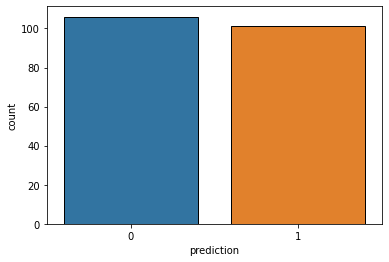

In [125]:
sns.countplot(in_0_or_1.prediction, edgecolor = (0, 0, 0))
plt.show()

#### score 확인 커스텀 함수

In [148]:
def get_score(actual, prediction) :
  acc = accuracy_score(actual, prediction)
  recall = recall_score(actual, prediction)
  f1 = f1_score(actual, prediction)
  fpr, tpr, _ = roc_curve(actual, prediction)
  AUC = auc(fpr, tpr)

  print(f'Accuracy : {acc}')
  print(f'Recall : {recall}')
  print(f'F1 : {f1}')
  print(f'AUC :  {AUC}')

In [127]:
get_score(in_0_or_1['actual'], in_0_or_1['prediction'])

Accuracy : 0.9806763285024155
Recall : 0.9619047619047619
F1 : 0.9805825242718447
AUC :  0.980952380952381


별도의 Csv로 저장

In [ ]:
X_test[X_test.prediction == 2].to_csv('cls_2.csv', index = False)
X_test[X_test.prediction == 1].to_csv('cls_1.csv', index = False)
X_test[X_test.prediction == 0].to_csv('cls_0.csv', index = False)

데이터중 t2값이 3인 인덱스 저장

In [128]:
idx3 = data[data.t2 == 3].index

3과 3이 아닌 데이터를 따로 저장

In [129]:
in_3 = data[data.t2 == 3]
not_in_3 = data[data.t2 != 3]

3인 데이터 모델링

In [132]:
X_test, y_test, tr_scaled, te_scaled = make_data(in_3)

In [ ]:
i = 0
dnn_pred = np.zeros((y_test.shape[0]))
for tr_idx, val_idx in skf.split(tr_scaled, y_train) :
  i += 1
  tr_x, tr_y = tr_scaled[tr_idx], y_train.iloc[tr_idx]
  val_x, val_y = tr_scaled[val_idx], y_train.iloc[val_idx]

  dnn_input = Input(shape = (8, ), name = 'dnn_input')
  dnn_layer = Dense(32, activation = 'swish')(dnn_input)
  dnn_layer = Dense(16, activation = 'swish')(dnn_layer)
  dnn_layer = Dropout(.3)(dnn_layer)
  dnn_layer = Dense(1, activation = 'sigmoid')(dnn_layer)
  dnn_model = Model(inputs = dnn_input, outputs = dnn_layer)

  dnn_model.compile(optimizer = RMSprop(learning_rate = .003), loss = 'binary_crossentropy', metrics = ['acc'])
  es = EarlyStopping(monitor = 'val_acc', patience = 10, verbose = 1)
  mc = ModelCheckpoint(f'dnn_model{i}.h5', monitor = 'val_acc', verbose = 1, save_best_only = True)
  dnn_model.fit(tr_x, tr_y, batch_size = 16, epochs = 100, validation_split = .2, callbacks = [es, mc])

  use_model = load_model(f'dnn_model{i}.h5')

  pred = [x[0] for x in use_model.predict(te_scaled) / 10]

  dnn_pred += pred

In [134]:
in_0_or_1 = make_pred_df(X_test, dnn_pred, y_test)

In [135]:
get_score(in_0_or_1['actual'], in_0_or_1['prediction'])

Accuracy : 0.9806763285024155
Recall : 0.9619047619047619
F1 : 0.9805825242718447
AUC :  0.980952380952381


3이 아닌 데이터 모델링

In [ ]:
X_test, y_test, tr_scaled, te_scaled = make_data(not_in_3)

In [ ]:
i = 0
dnn_pred = np.zeros((y_test.shape[0]))
for tr_idx, val_idx in skf.split(tr_scaled, y_train) :
  i += 1
  tr_x, tr_y = tr_scaled[tr_idx], y_train.iloc[tr_idx]
  val_x, val_y = tr_scaled[val_idx], y_train.iloc[val_idx]

  dnn_input = Input(shape = (8, ), name = 'dnn_input')
  dnn_layer = Dense(32, activation = 'swish')(dnn_input)
  dnn_layer = Dense(32, activation = 'swish')(dnn_layer)
  dnn_layer = Dropout(.3)(dnn_layer)
  dnn_layer = Dense(8, activation = 'swish')(dnn_layer)
  dnn_layer = Dense(1, activation = 'sigmoid')(dnn_layer)
  dnn_model = Model(inputs = dnn_input, outputs = dnn_layer)

  dnn_model.compile(optimizer = Adam(learning_rate = .003), loss = 'binary_crossentropy', metrics = ['acc'])
  es = EarlyStopping(monitor = 'val_acc', patience = 10, verbose = 1)
  mc = ModelCheckpoint(f'dnn_model{i}.h5', monitor = 'val_acc', verbose = 1, save_best_only = True)
  dnn_model.fit(tr_x, tr_y, batch_size = 16, epochs = 100, validation_split = .2, callbacks = [es, mc])

  use_model = load_model(f'dnn_model{i}.h5')

  pred = [x[0] for x in use_model.predict(te_scaled) / 10]

  dnn_pred += pred

In [ ]:
in_0_or_1 = make_pred_df(X_test, dnn_pred, y_test)

In [ ]:
get_score(in_0_or_1['actual'], in_0_or_1['prediction'])

파라미터 조정 -> 케라스 튜너 사용

In [19]:
!pip install -q -U keras-tuner
import kerastuner as kt
from kerastuner.tuners import RandomSearch

In [139]:
X_test, y_test, tr_scaled, te_scaled = make_data(data)

In [140]:
def build_model(hp):
  model = Sequential()
  model.add(Dense(
      hp.Choice('units', [8, 16, 32]),
      activation='swish'))
  model.add(Dense(hp.Choice('units', [8,16,32]), activation = 'swish'))
  model.add(Dropout(.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer = RMSprop(learning_rate = .003), loss = 'binary_crossentropy', metrics = ['acc'])
  return model

In [141]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_acc',
    max_trials = 15,
    seed = 42)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [142]:
tuner.search(tr_scaled, y_train, epochs = 20, validation_split = .2)
best_model = tuner.get_best_models()[0]

INFO:tensorflow:Oracle triggered exit


In [143]:
kt_pred = best_model.predict(te_scaled)

In [149]:
in_0_or_1 = make_pred_df(X_test, kt_pred, y_test)

In [150]:
get_score(in_0_or_1['actual'], in_0_or_1['prediction'])

Accuracy : 0.968
Recall : 0.8260869565217391
F1 : 0.9047619047619047
AUC :  0.9130434782608696
